# Hudson plot

## Aim

Create mirrored plots for the joint visualization and comparison of different phenotypes or LMM methods

# Command interface

In [3]:
sos run Hudson_plot.ipynb -h

usage: sos run /home/dc2325/project/UKBB_GWAS_DEV/workflow/Hudson_plot.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  hudson

Global Workflow Options:
  --cwd VAL (as path, required)
                        the output directory for generated files
  --sumstats-1 VAL (as path, required)
                        GWAS summary statistic file for phenotype/method 1
  --sumstats-2 VAL (as path, required)
                        GWAS summary statistic file for phenotype/method 2
  --toptitle VAL (as str, required)
                        Top Title for the plot
  --bottomtitle VAL (as str, required)
                        Bottom Title for the plot
  --job-size 1 (as int)

## Illustration with minimal working examples

### Hudson plot example command

On a minimal working example (MWE) dataset,

```
sos run Hudson_plot.ipynb hudson  \
    --cwd output \
    --sumstats_1 output/phenotypes_WAIST.fastGWA.snp_stats.gz \
    --sumstats_2 output/phenotypes_BMI.fastGWA.snp_stats.gz \
    --toptitle Waist \
    --bottomtitle BMI \
    --highlight_p_top 0.1 \
    --highlight_p_bottom 0.1 \
    --pval_filter 1 \
    --container_lmm lmm_v1_2.sif
```

## Visualization of the plot created (e.g real tinnitus data from UK Biobank)

> /home/dc2325/output/200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus.fastGWA_200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus_p2.fastGWA.hudson.png (2.3 MiB):

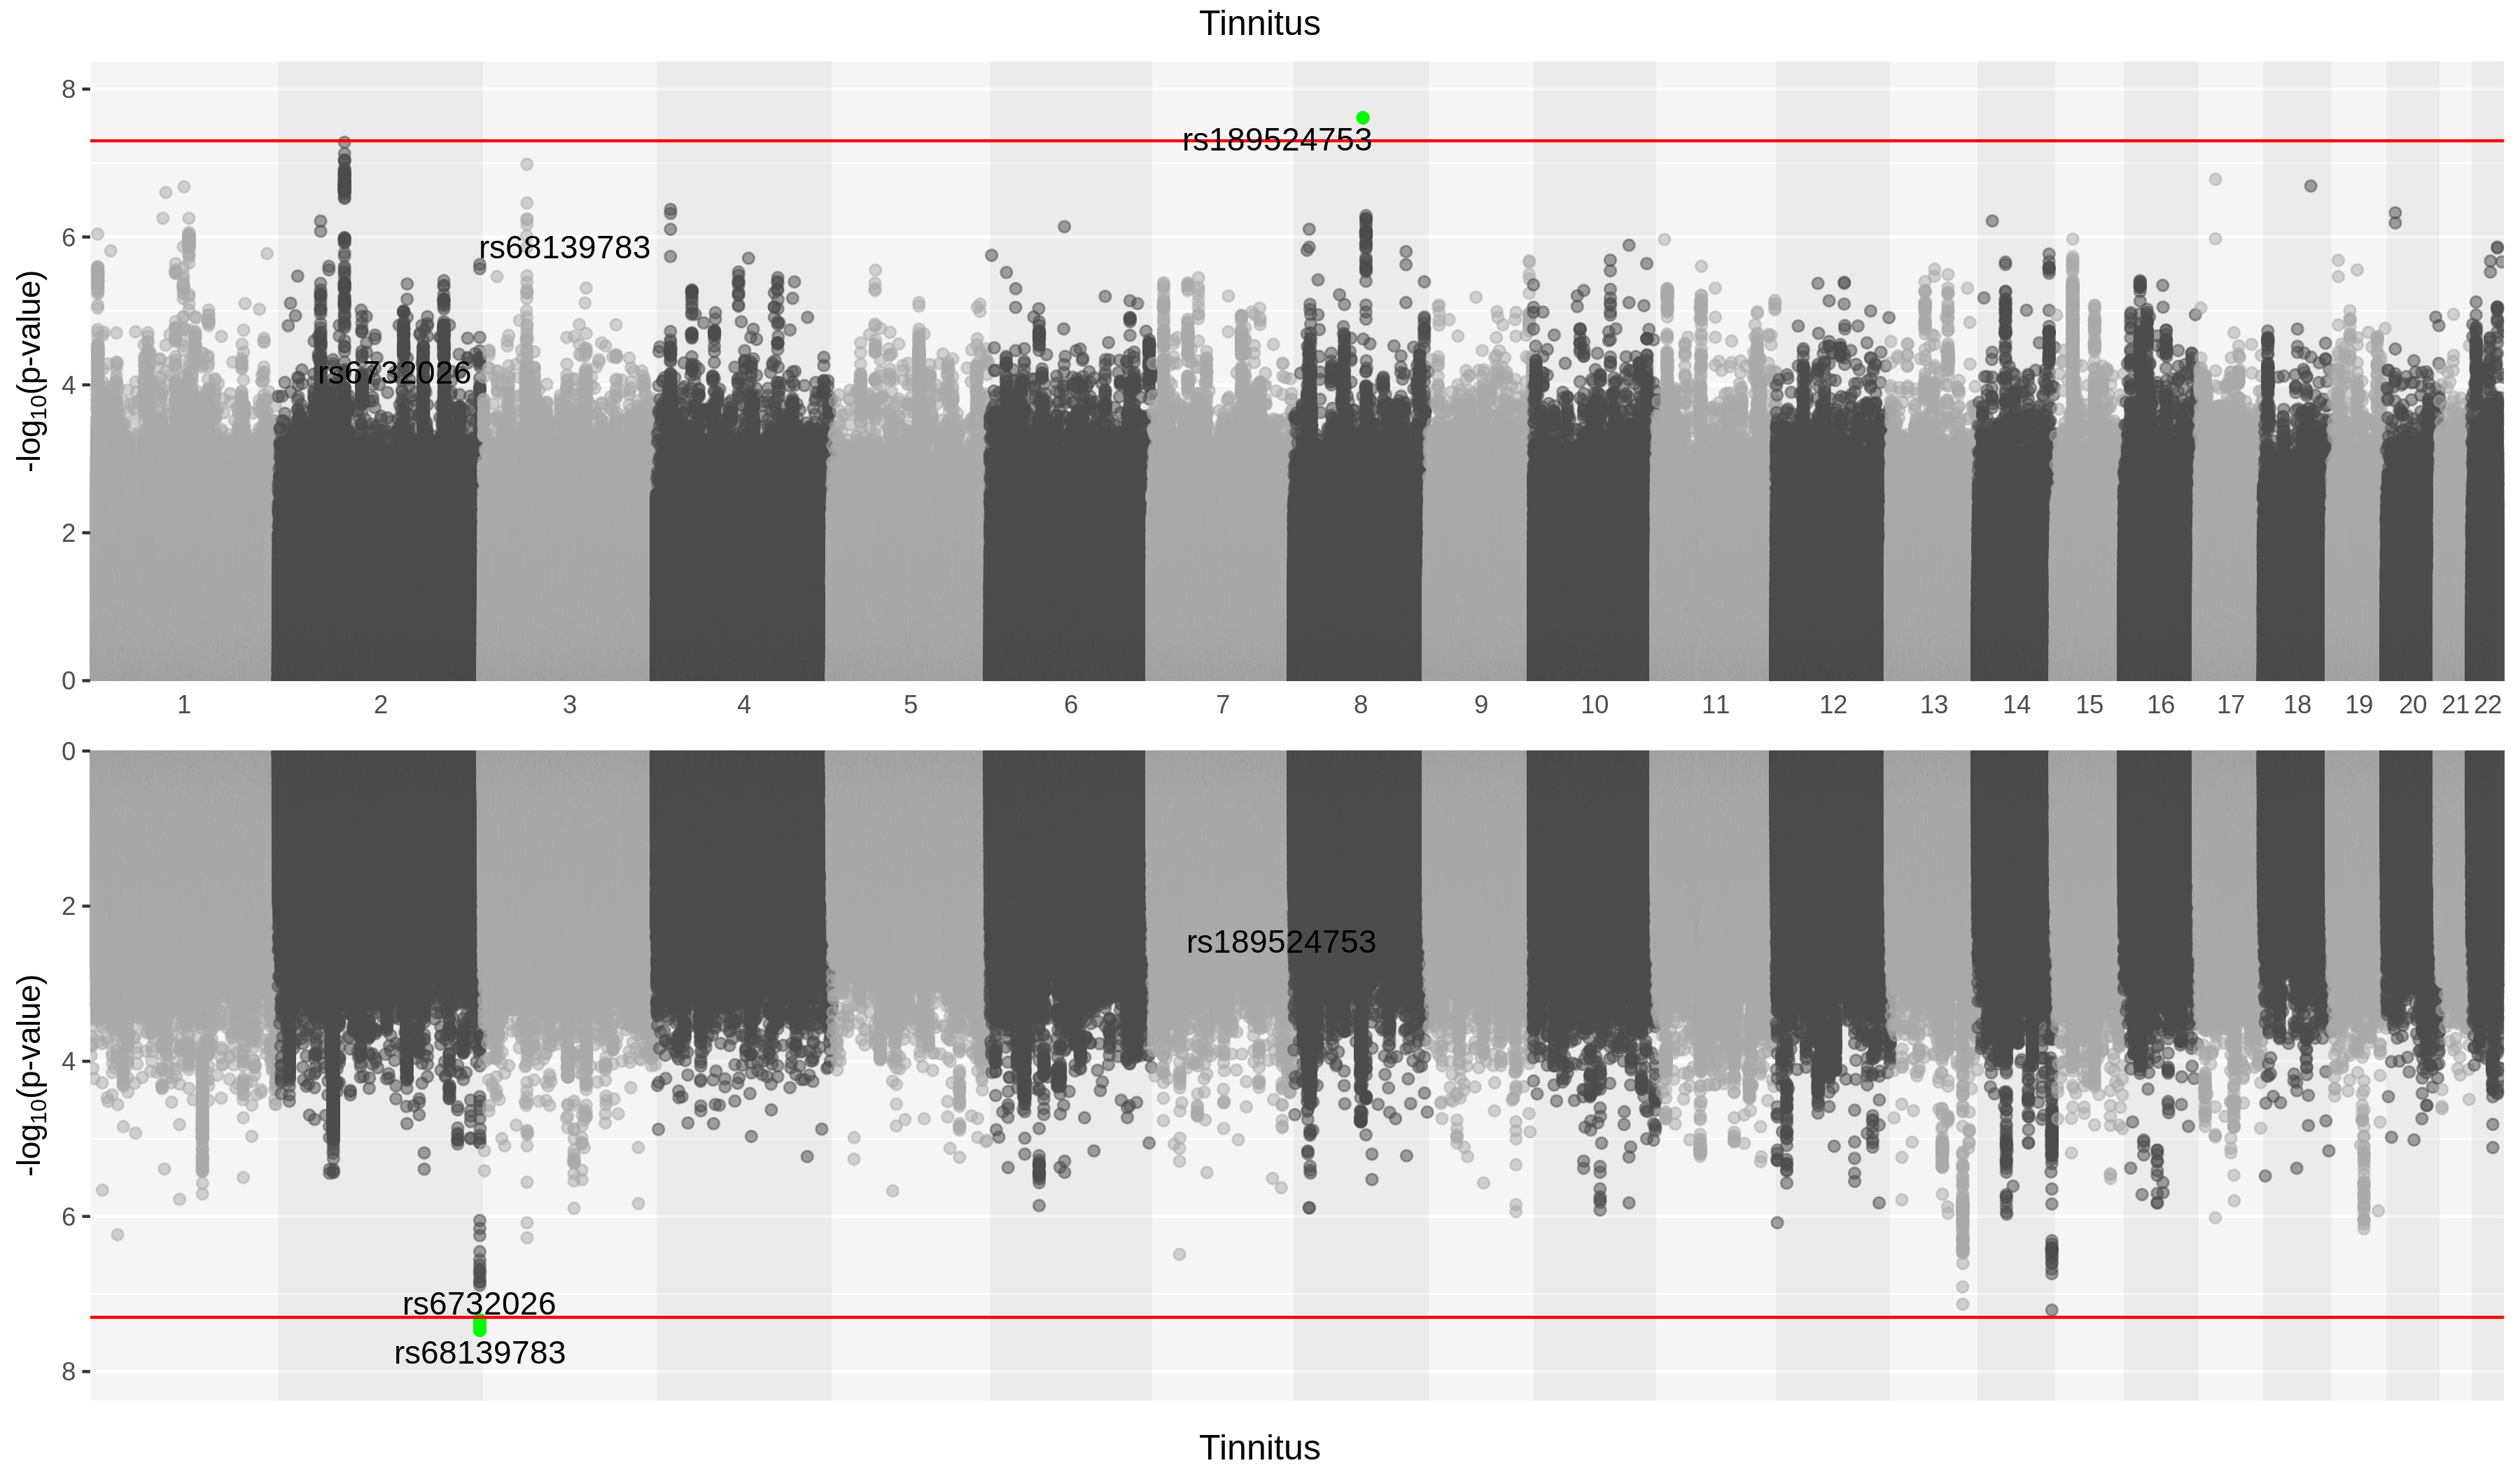

>>> ~/output/200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus.fastGWA_200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus_p2.fastGWA.hudson.png:

bash: /home/dc2325/output/200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus.fastGWA_200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus_p2.fastGWA.hudson.png: Permission denied



In [1]:
%preview -s png ~/output/200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus.fastGWA_200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus_p2.fastGWA.hudson.png

In [ ]:
[global]
# the output directory for generated files
parameter: cwd = path
# GWAS summary statistic file for phenotype/method 1
parameter: sumstats_1 = path
#  GWAS summary statistic file for phenotype/method 2
parameter: sumstats_2 = path
# Top Title for the plot
parameter: toptitle=str
# Bottom Title for the plot
parameter: bottomtitle=str
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Specific number of threads to use
parameter: numThreads = 2
# Column name for BP file 1
parameter: bp1 = 'POS'
# Column name for p-value file 1
parameter: pval1 = 'P'
# Column name for SNP file 1
parameter: snp1 = 'SNP'
# Column name for BP file 2
parameter: bp2 = 'POS'
# Column name for p-value file 2
parameter: pval2 = 'P'
# Column name for SNP file 2
parameter: snp2 = 'SNP'
# P value use to highlight variants
parameter: highlight_p_top = 0.0
parameter: highlight_p_bottom = 0.0
#P value filter to select the significant SNPs
parameter: pval_filter = 0.0
# The container with the lmm software. Can be either a dockerhub image or a singularity `sif` file.
parameter: container_lmm = 'statisticalgenetics/lmm:2.9'

In [ ]:
[hudson_1]
# Name of trait number 1
parameter: phenocol1 = str
# Name of trait number 2
parameter: phenocol2 = str
input:sumstats_1, sumstats_2
output: f'{cwd}/{sumstats_1:bnn}_{sumstats_2:bnn}.snplist', f'{cwd}/{sumstats_1:bnn}_{sumstats_2:bnn}.snplist.summary'
task: trunk_workers = 1, walltime = '1h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
python: container=container_lmm, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    import pandas as pd
    sumstats_1 = pd.read_csv('${_input[0]}', compression='gzip', header=0, sep='\t', quotechar='"')
    sumstats_2 = pd.read_csv('${_input[1]}', compression='gzip', header=0, sep='\t', quotechar='"')
    sig_1=sumstats_1[sumstats_1.P<${pval_filter}]
    sig_2=sumstats_2[sumstats_2.P<${pval_filter}]
    intersect = sig_1.SNP[sig_1.SNP.isin(sig_2.SNP)]
    res1 = sig_1[sig_1.SNP.isin(intersect)]
    res1.columns = ['CHR', 'POS', 'REF', 'ALT', 'SNP', 'BETA_${phenocol1}', 'SE_${phenocol1}', 'P_${phenocol1}']
    res2 = sig_2[sig_2.SNP.isin(intersect)]
    res2.columns = ['CHR', 'POS', 'REF', 'ALT', 'SNP', 'BETA_${phenocol2}', 'SE_${phenocol2}', 'P_${phenocol2}']
    res3 = pd.merge(res1, res2, on=['SNP', 'CHR', 'POS', 'REF', 'ALT'])
    intersect.to_csv(${_output[0]:r}, sep=' ', header = False, index = False)
    res3.to_csv(${_output[1]:r}, sep='\t', header = True, index = False)

In [ ]:
# Hudson plots for two traits
[hudson_2]
# SNP list to highlight
parameter: highlight_snp = [line.strip() for line in open(f'{cwd}/{sumstats_1:bnn}_{sumstats_2:bnn}.snplist', 'r')]
# SNP list to annotate
parameter: annotate_snp = [] #[line.strip() for line in open(f'{highlight_snp}', 'r')]
input: sumstats_1, sumstats_2
output: f'{cwd}/{sumstats_1:bnn}_{sumstats_2:bnn}.hudson.png'
task: trunk_workers = 1, walltime = '10h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: container=container_lmm, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    library('hudson')
    library('ggplot2')
    library('ggrepel')
    library('dplyr')
    # Import relevant sumstats
    gwas.1 <- read.table(gzfile('${_input[0]}'), sep='\t', header=T)
    gwas.2 <- read.table(gzfile('${_input[1]}'), sep='\t', header=T)
  
    # Create the dataframes with useful info
    qqdat1 <- data.frame(SNP=gwas.1$${snp1},CHR=gwas.1$CHR,POS=gwas.1$${bp1}, pvalue=gwas.1$${pval1},length.out=nrow(gwas.1), each=1)
    qqdat1 <- qqdat1 %>%
        filter(pvalue < 0.05)
    qqdat2 <- data.frame(SNP=gwas.2$${snp2},CHR=gwas.2$CHR,POS=gwas.2$${bp2}, pvalue=gwas.2$${pval2},length.out=nrow(gwas.2), each=1)
    qqdat2 <- qqdat2 %>%
        filter(pvalue < 0.05)
  
    #Create mirror plot
    gmirror(top=qqdat1, bottom=qqdat2, tline=5e-08, bline=5e-08, 
            toptitle="${toptitle}", bottomtitle="${bottomtitle}", log10=TRUE, opacity=0.5,
            annotate_snp = c(${','.join(['"%s"' % x for x in annotate_snp if x is not None])}),
            highlight_snp = c(${','.join(['"%s"' % x for x in highlight_snp if x is not None])}),
            highlight_p = c(${highlight_p_top},${highlight_p_bottom}), highlighter="red", background='white', freey = TRUE,
            file='${_output:n}', res=300)